In [2]:
import pandas as pd                                       #importing pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv("2010_2023_3tops.csv",low_memory=False)


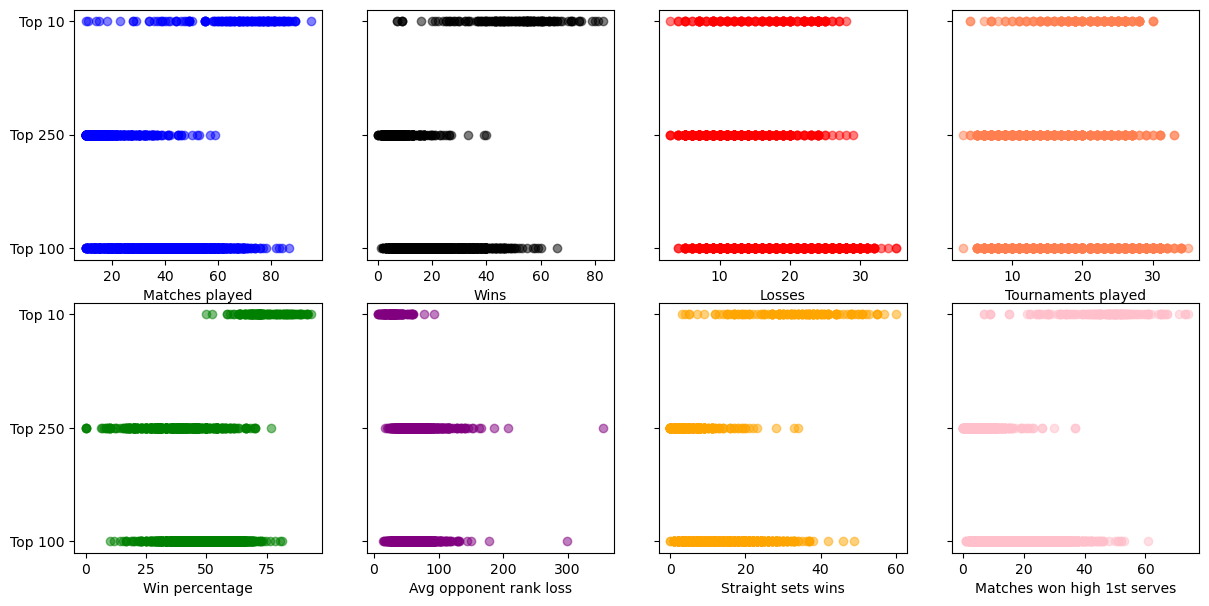

In [4]:
import matplotlib.pyplot as plt

# Lista de columnas y sus colores
columns = [
    ('matches_played', 'blue'),
    ('wins', 'black'),
    ('losses', 'red'),
    ('tournaments_played', 'coral'),
    ('win_percentage', 'green'),
    ('avg_opponent_rank_loss', 'purple'),
    ('straight_sets_wins', 'orange'),
    ('matches_won_high_1st_serves', 'pink')
]

# Crear la figura con 2 filas y 4 columnas; se comparte el eje y para mantenerlo consistente.
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True)
fig.tight_layout(pad=1.0)  # Ajustar el espacio entre subplots

# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()

# Graficar cada variable contra 'ranking_group'
for ax, (col, color) in zip(axes, columns):
    ax.scatter(data[col], data['ranking_group'], c=color, alpha=0.5)
    ax.set_xlabel(col.replace('_', ' ').capitalize())
    
    # No asignamos la etiqueta del eje y en cada subplot

# Agregar una etiqueta común para el eje y en toda la figura.
# Nota: 'supylabel' está disponible en matplotlib 3.4+.

plt.show()



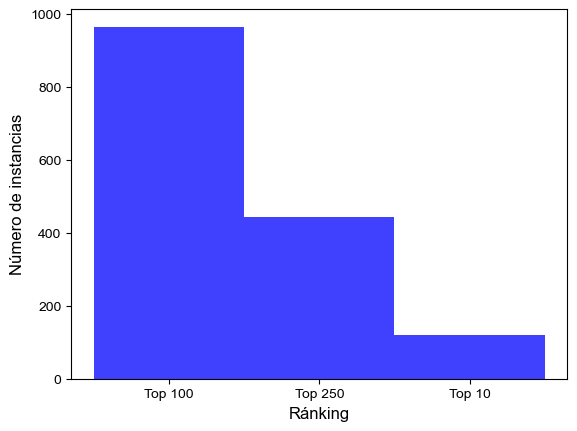

In [5]:
from sklearn.model_selection import train_test_split
# Dividir en conjuntos de entrenamiento y prueba
X = data[["matches_played","wins","losses","tournaments_played","win_percentage","avg_opponent_rank_loss","straight_sets_wins","matches_won_high_1st_serves"]]
y = data['ranking_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hplot = sns.histplot(y_train, color="blue", label="Ránking", linewidth=0, bins=100)
hplot.set_xlabel("Ránking", fontsize = 12)
hplot.set_ylabel("Número de instancias", fontsize = 12)
sns.set(rc={"figure.figsize":(4, 2)})

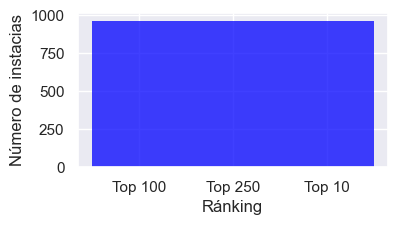

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
hplot = sns.histplot(y_train_balanced, color="blue", label="Ránking", linewidth=0, bins=100)
hplot.set_xlabel("Ránking", fontsize = 12)
hplot.set_ylabel("Número de instacias", fontsize = 12)
sns.set(rc={"figure.figsize":(4,2)})


In [7]:
# Mapeo de ranking_group a valores numéricos
ranking_group_mapping = {
    "Top 10": 0,
    "Top 100": 1,
    "Top 250": 2
}
# Ajustar y transformar el conjunto de entrenamiento
y_train = y_train.map(ranking_group_mapping)
y_test = y_test.map(ranking_group_mapping)


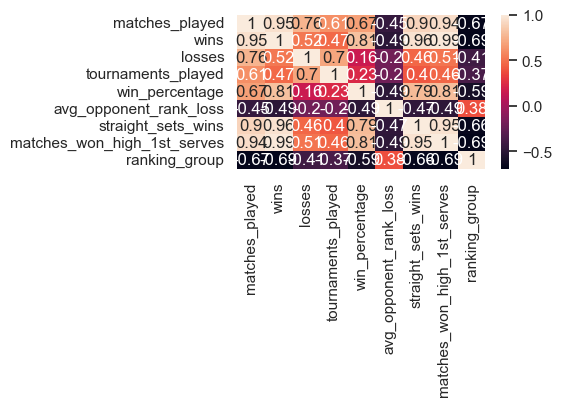

In [8]:
data=pd.read_csv("2010_2023_3tops.csv",low_memory=False)
data["ranking_group"]=data["ranking_group"].map(ranking_group_mapping)
sns.heatmap(data[["matches_played","wins","losses","tournaments_played","win_percentage","avg_opponent_rank_loss","straight_sets_wins","matches_won_high_1st_serves","ranking_group"]].corr(),annot=True)
plt.show()

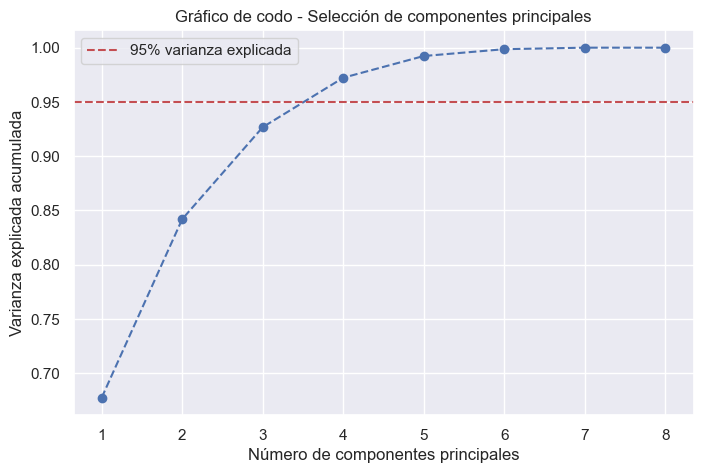

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Ajustar PCA
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza explicada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Gráfico de codo - Selección de componentes principales')
plt.legend()
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from collections import Counter

models = {
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [10,50,100, 150, 200,500],
            "criterion": ["gini", "entropy", "log_loss"],
            "max_depth": [5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 3, 4, 5],
            "min_weight_fraction_leaf": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
            "max_features": ["sqrt","log2", None]
        }
    },
    "SVM": {
        "estimator": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "Logistic Regression": {
        "estimator": LogisticRegression(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"]
        }
    },
    "k-NN": {
        "estimator": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 10],
            "weights": ["uniform", "distance"]
        }
    }
}

# Entrenar y evaluar cada modelo con GridSearchCV
results = {}

for model_name, config in models.items():
    # Configurar GridSearchCV
    grid = GridSearchCV(
        estimator=config["estimator"],  # Pasar el modelo directamente
        param_grid=config["params"],  # Pasar hiperparámetros
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Entrenar y guardar resultados
    grid.fit(X_train_balanced, y_train_balanced)
    results[model_name] = {
        "best_params": grid.best_params_,
        "best_score": grid.best_score_,
        "model": grid.best_estimator_
    }
    print(f"Modelo: {model_name}")
    print(f"Mejor Score: {grid.best_score_}")
    print(f"Mejores Hiperparámetros: {grid.best_params_}\n")

# Evaluar el mejor modelo de cada tipo en el conjunto de prueba
for model_name, result in results.items():
    print(f"Resultados para {model_name}:")
    y_pred = result["model"].predict(X_test)
    y_pred = np.vectorize(ranking_group_mapping.get)(y_pred)
    print(classification_report(y_test, y_pred))
 

Fitting 5 folds for each of 14580 candidates, totalling 72900 fits


KeyboardInterrupt: 

In [9]:
for s in range (1,8):

    # Algoritmo de Optimización por Enjambre de Partículas (PSO).
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, classification_report, precision_score, make_scorer, f1_score
    # Librerías utilizadas.
    import time
    import numpy as np
    import random
    import numpy.matlib

    # RANDOM FOREST 
    criterion_map_rf = {0: "gini", 1: "entropy", 2: "log_loss"}
    max_features_map_rf = {0: "sqrt", 1: "log2", 2: None}

    hyperparameter_space = {
                "n_estimators_values": [10, 50, 100, 200, 500],
                "max_depth_values": [5, 10, 20],
                "criterion_values": [0, 1, 2],
                "min_samples_split_values": [2, 5, 10],
                "min_samples_leaf_values": [1, 2, 3, 4, 5],
                "min_weight_fraction_leaf_values": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                "max_features_values": [0, 1, 2]
            }
    # FUNCIÓN OBJETIVO 

    def funObj(x):  
        # 2) Definimos el modelo con esos hiperparámetros
        model = RandomForestClassifier(n_estimators = round(x[0]), max_depth= round(x[1]), criterion = criterion_map_rf[round(x[2])], min_samples_split = round(x[3]),
                                        min_samples_leaf = round(x[4]), min_weight_fraction_leaf = round(x[5], 2), max_features = max_features_map_rf[round(x[6])])
        
        # 2. Evaluar con validación cruzada y la métrica que desees (ej: f1_macro)
        scores = cross_val_score(
            model, 
            X_train_balanced, 
            y_train_balanced, 
            scoring="f1_macro",  # o "balanced_accuracy", según convenga
            cv=5,  # Usar validación personalizada
            n_jobs=-1  # si quieres usar multiproceso
        )

        # 3. El fitness a minimizar será 1 - promedio(scores), para maximizar la métrica
        return 1 - scores.mean()
        return 1 - f1


    # 1. INICIALIZACIÓN
    ####################

    ## Configuración de parámetros.
    d = len(hyperparameter_space.keys()) # Dimensión del espacio de búsqueda 
    N = 2*s + 1  # Número de partículas
    it = 0 # Iteración inicial
    it_max = 30 # Número máximo de iteraciones (criterio de paro: k = it_max)
    c1 = 0.5 # Constante cognitiva
    c2 = 0.5 # Constante social
    k=0.5
    w=0.9
    Evolucion = np.zeros(it_max + 1) # Vector que recoge el mejor fitness global de cada iteración.
    lb = [0] * d
    ub = [0] * d
    ## Definición de la clase Particula.
    class Particula():
        """
        Representa a una partícula del algoritmo PSO.
        """
        def __init__(self):
            """
            Atributos de instancia:
                posicion (numpy.ndarray) : posición de la partícula de dimensión d.
                
                velocidad (numpy.ndarray) : velocidad de la partícula de dimensión d.
                
                fit (numpy.ndarray) : valor de fitness de la partícula.
                
                mejor_fitness_local (float) : valor del mejor fitness de la partícula.
                
                mejor_posicion_local (numpy.ndarray) : posición de la partícula cuando alcanza el mejor_fitness_local.
            """
            self.posicion = np.repeat(None, d)
            self.velocidad = np.zeros(d) # Velocidad inicial = 0
            self.fit = np.array(None)
            self.mejor_fitness_local = None
            self.mejor_posicion_local = None
    
    ## Definición del enjambre, conjunto de partículas.
    Particulas = np.array([])
    for i in range(N):
        particula = Particula()
        Particulas = np.append(Particulas,particula)

    for j in range(d):
        lb[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][0]
        ub[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][len(hyperparameter_space[list(hyperparameter_space.keys())[j]])-1]
    ## Inicialización del enjambre.
    start_time = time.time()
    for k in range(N):
        Particulas[k].posicion = [np.random.uniform(lb[j],ub[j]) for j in range(d)]
        Particulas[k].fit = funObj(Particulas[k].posicion)
        # Mejor fitness local de cada partícula
        Particulas[k].mejor_fitness_local = Particulas[k].fit
        # Mejor posición local de cada partícula
        Particulas[k].mejor_posicion_local = Particulas[k].posicion
        if k == 0:
            mejor_fitness_global = Particulas[k].fit
        else:
            if Particulas[k].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[k].mejor_fitness_local
                mejor_posicion_global = Particulas[k].mejor_posicion_local
    iteration_time = time.time() - start_time    
    Evolucion[0] = mejor_fitness_global
    print("Iteracion ", str(0), ": Costo(Fitness) = ",str(1-Evolucion[0]),"Tiempo de iteración: ", iteration_time, mejor_posicion_global)


    # 2. PROCESO ITERATIVO
    #######################

    while it < it_max: # Criterio de paro
        it += 1
        start_time = time.time()
        # Cálculo de la nueva velocidad y posición de cada partícula:
        for i in range(N):
            posicion_array = np.array(Particulas[i].posicion)
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local)

            # Perform element-wise subtraction and update w
            w = w + 0.5 * np.exp(-np.abs(posicion_array - mejor_posicion_local_array))
            # Ensure that Particulas[i].mejor_posicion_local and Particulas[i].posicion are NumPy arrays
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local, dtype=float)
            posicion_array = np.array(Particulas[i].posicion, dtype=float)
            mejor_posicion_global_array= np.array(mejor_posicion_global, dtype=float)  
            # Perform element-wise subtraction and multiplication
        
            parte1 = c1 * random.uniform(0, 1) * (mejor_posicion_local_array - posicion_array)    
            parte2 = c2 * random.uniform(0,1) * (mejor_posicion_global_array - posicion_array)
            
            nueva_velocidad = w*Particulas[i].velocidad + parte1 + parte2
            Particulas[i].velocidad = nueva_velocidad
            Particulas[i].posicion = Particulas[i].posicion + Particulas[i].velocidad
            # Verificar que las partículas no se salgan de los límites lb y ub:
            for j in range(d):
                if  Particulas[i].posicion[j] < lb[j]:
                    Particulas[i].posicion[j] = lb[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                elif Particulas[i].posicion[j] > ub[j]:
                    Particulas[i].posicion[j] = ub[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                if Particulas[i].velocidad[j] < -k*(ub[j]-lb[j]):
                    Particulas[i].velocidad[j] = 0
                elif Particulas[i].velocidad[j] > k*(ub[j]-lb[j]):
                    Particulas[i].velocidad[j] = 0



            Particulas[i].fit = funObj(Particulas[i].posicion)   
            # Mejor fitness local de cada partícula
            if Particulas[i].fit < Particulas[i].mejor_fitness_local:
                Particulas[i].mejor_fitness_local = Particulas[i].fit
                Particulas[i].mejor_posicion_local = Particulas[i].posicion
            # Fitness global  
            if  Particulas[i].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[i].mejor_fitness_local
                mejor_posicion_global = Particulas[i].mejor_posicion_local
        
        Evolucion[it] = mejor_fitness_global
        # Mostrar iteración actual y mejor fitness actual
        iteration_time = time.time() - start_time
        print("Iteracion ", str(it), ": Costo(Fitness) = ",str(1-Evolucion[it]), "Tiempo de iteración: ", iteration_time, mejor_posicion_global)
    
    



Iteracion  0 : Costo(Fitness) =  0.8326848249996331 Tiempo de iteración:  10.804375648498535 [124.55164861725403, 7.3094718664604486, 0.3626014577523904, 5.990158147441919, 3.3177924488365824, 0.10179317022282663, 0.8402476322120045]
Iteracion  1 : Costo(Fitness) =  0.8332657217724491 Tiempo de iteración:  3.6350886821746826 [1.24551649e+02 7.30947187e+00 3.62601458e-01 5.99015815e+00
 3.31779245e+00 1.01793170e-01 8.40247632e-01]
Iteracion  2 : Costo(Fitness) =  0.8332657217724491 Tiempo de iteración:  2.4802615642547607 [1.24551649e+02 7.30947187e+00 3.62601458e-01 5.99015815e+00
 3.31779245e+00 1.01793170e-01 8.40247632e-01]
Iteracion  3 : Costo(Fitness) =  0.8538001115957996 Tiempo de iteración:  1.8729844093322754 [95.05181774  5.          0.          9.5365217   4.27976901  0.
  1.3518835 ]
Iteracion  4 : Costo(Fitness) =  0.8538001115957996 Tiempo de iteración:  1.1947741508483887 [95.05181774  5.          0.          9.5365217   4.27976901  0.
  1.3518835 ]
Iteracion  5 : Costo

KeyboardInterrupt: 

In [ ]:
for s in range (1,8):

    # Algoritmo de Optimización por Enjambre de Partículas (PSO).
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, classification_report, precision_score, make_scorer, f1_score
    # Librerías utilizadas.
    import time
    import numpy as np
    import random
    import numpy.matlib

    # RANDOM FOREST 
    criterion_map_rf = {0: "gini", 1: "entropy", 2: "log_loss"}
    max_features_map_rf = {0: "sqrt", 1: "log2", 2: None}

    hyperparameter_space = {
                "n_estimators_values": [10, 50, 100, 200, 500],
                "max_depth_values": [5, 10, 20],
                "criterion_values": [0, 1, 2],
                "min_samples_split_values": [2, 5, 10],
                "min_samples_leaf_values": [1, 2, 3, 4, 5],
                "min_weight_fraction_leaf_values": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                "max_features_values": [0, 1, 2]
            }
    # FUNCIÓN OBJETIVO 

    def funObj(x):  
        # 2) Definimos el modelo con esos hiperparámetros
        model = RandomForestClassifier(n_estimators = round(x[0]), max_depth= round(x[1]), criterion = criterion_map_rf[round(x[2])], min_samples_split = round(x[3]),
                                        min_samples_leaf = round(x[4]), min_weight_fraction_leaf = round(x[5], 2), max_features = max_features_map_rf[round(x[6])])
        
        # 2. Evaluar con validación cruzada y la métrica que desees (ej: f1_macro)
        scores = cross_val_score(
            model, 
            X_train_balanced, 
            y_train_balanced, 
            scoring="f1_macro",  # o "balanced_accuracy", según convenga
            cv=5,  # Usar validación personalizada
            n_jobs=-1  # si quieres usar multiproceso
        )

        # 3. El fitness a minimizar será 1 - promedio(scores), para maximizar la métrica
        return 1 - scores.mean()
        return 1 - f1


    # 1. INICIALIZACIÓN
    ####################

    ## Configuración de parámetros.
    d = len(hyperparameter_space.keys()) # Dimensión del espacio de búsqueda 
    N = 2*s + 1  # Número de partículas
    it = 0 # Iteración inicial
    it_max = 30 # Número máximo de iteraciones (criterio de paro: k = it_max)
    c1 = 2 # Constante cognitiva
    c2 = 2 # Constante social
    k=0.5
    w=0.9
    Evolucion = np.zeros(it_max + 1) # Vector que recoge el mejor fitness global de cada iteración.
    lb = [0] * d
    ub = [0] * d
    ## Definición de la clase Particula.
    class Particula():
        """
        Representa a una partícula del algoritmo PSO.
        """
        def __init__(self):
            """
            Atributos de instancia:
                posicion (numpy.ndarray) : posición de la partícula de dimensión d.
                
                velocidad (numpy.ndarray) : velocidad de la partícula de dimensión d.
                
                fit (numpy.ndarray) : valor de fitness de la partícula.
                
                mejor_fitness_local (float) : valor del mejor fitness de la partícula.
                
                mejor_posicion_local (numpy.ndarray) : posición de la partícula cuando alcanza el mejor_fitness_local.
            """
            self.posicion = np.repeat(None, d)
            self.velocidad = np.zeros(d) # Velocidad inicial = 0
            self.fit = np.array(None)
            self.mejor_fitness_local = None
            self.mejor_posicion_local = None
    
    ## Definición del enjambre, conjunto de partículas.
    Particulas = np.array([])
    for i in range(N):
        particula = Particula()
        Particulas = np.append(Particulas,particula)

    for j in range(d):
        lb[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][0]
        ub[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][len(hyperparameter_space[list(hyperparameter_space.keys())[j]])-1]
    ## Inicialización del enjambre.
    for k in range(N):
        Particulas[k].posicion = [np.random.uniform(lb[j],ub[j]) for j in range(d)]
        Particulas[k].fit = funObj(Particulas[k].posicion)
        # Mejor fitness local de cada partícula
        Particulas[k].mejor_fitness_local = Particulas[k].fit
        # Mejor posición local de cada partícula
        Particulas[k].mejor_posicion_local = Particulas[k].posicion
        if k == 0:
            mejor_fitness_global = Particulas[k].fit
        else:
            if Particulas[k].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[k].mejor_fitness_local
                mejor_posicion_global = Particulas[k].mejor_posicion_local

    Evolucion[0] = mejor_fitness_global
    print("Iteracion ", str(0), ": Costo(Fitness) = ",str(1-Evolucion[0]),"Tiempo de iteración: ", iteration_time, mejor_posicion_global)


    # 2. PROCESO ITERATIVO
    #######################

    while it < it_max: # Criterio de paro
        it += 1
        start_time = time.time()
        # Cálculo de la nueva velocidad y posición de cada partícula:
        for i in range(N):
            posicion_array = np.array(Particulas[i].posicion)
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local)

            # Perform element-wise subtraction and update w
            #w = w + 0.5 * np.exp(-np.abs(posicion_array - mejor_posicion_local_array))
            # Ensure that Particulas[i].mejor_posicion_local and Particulas[i].posicion are NumPy arrays
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local, dtype=float)
            posicion_array = np.array(Particulas[i].posicion, dtype=float)
            mejor_posicion_global_array= np.array(mejor_posicion_global, dtype=float)  
            # Perform element-wise subtraction and multiplication
        
            parte1 = c1 * random.uniform(0, 1) * (mejor_posicion_local_array - posicion_array)    
            parte2 = c2 * random.uniform(0,1) * (mejor_posicion_global_array - posicion_array)
            
            nueva_velocidad = w*Particulas[i].velocidad + parte1 + parte2
            Particulas[i].velocidad = nueva_velocidad
            Particulas[i].posicion = Particulas[i].posicion + Particulas[i].velocidad
            # Verificar que las partículas no se salgan de los límites lb y ub:
            for j in range(d):
                if  Particulas[i].posicion[j] < lb[j]:
                    Particulas[i].posicion[j] = lb[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                elif Particulas[i].posicion[j] > ub[j]:
                    Particulas[i].posicion[j] = ub[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                #if Particulas[i].velocidad[j] < -k*(ub[j]-lb[j]):
                 #   Particulas[i].velocidad[j] = 0
                #elif Particulas[i].velocidad[j] > k*(ub[j]-lb[j]):
                 #   Particulas[i].velocidad[j] = 0



            Particulas[i].fit = funObj(Particulas[i].posicion)   
            # Mejor fitness local de cada partícula
            if Particulas[i].fit < Particulas[i].mejor_fitness_local:
                Particulas[i].mejor_fitness_local = Particulas[i].fit
                Particulas[i].mejor_posicion_local = Particulas[i].posicion
            # Fitness global  
            if  Particulas[i].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[i].mejor_fitness_local
                mejor_posicion_global = Particulas[i].mejor_posicion_local
        
        Evolucion[it] = mejor_fitness_global
        # Mostrar iteración actual y mejor fitness actual
        iteration_time = time.time() - start_time
        print("Iteracion ", str(it), ": Costo(Fitness) = ",str(1-Evolucion[it]), "Tiempo de iteración: ", iteration_time, mejor_posicion_global)
    
    



Iteracion  0 : Costo(Fitness) =  0.844326710572133 Tiempo de iteración:  41.37213754653931 [187.93831533267067, 14.636884006999338, 1.0722327711335071, 4.651553295551543, 4.675731708635638, 0.0245675369760483, 0.3512598758505132]
Iteracion  1 : Costo(Fitness) =  0.8481331414967961 Tiempo de iteración:  10.05539846420288 [1.87938315e+02 1.46368840e+01 1.07223277e+00 4.65155330e+00
 4.67573171e+00 2.45675370e-02 3.51259876e-01]
Iteracion  2 : Costo(Fitness) =  0.8481724826617262 Tiempo de iteración:  10.212698936462402 [1.87938315e+02 1.46368840e+01 1.07223277e+00 4.65155330e+00
 4.67573171e+00 2.45675370e-02 3.51259876e-01]
Iteracion  3 : Costo(Fitness) =  0.8708445526907489 Tiempo de iteración:  8.590256452560425 [103.95779305  13.63458877   1.2812493    4.890458     4.75267389
   0.           0.        ]
Iteracion  4 : Costo(Fitness) =  0.8708445526907489 Tiempo de iteración:  6.629370450973511 [103.95779305  13.63458877   1.2812493    4.890458     4.75267389
   0.           0.       

In [ ]:
for s in range (1,8):

    # Algoritmo de Optimización por Enjambre de Partículas (PSO).
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, classification_report, precision_score, make_scorer, f1_score
    # Librerías utilizadas.
    import time
    import numpy as np
    import random
    import numpy.matlib

    # RANDOM FOREST 
    criterion_map_rf = {0: "gini", 1: "entropy", 2: "log_loss"}
    max_features_map_rf = {0: "sqrt", 1: "log2", 2: None}

    hyperparameter_space = {
                "n_estimators_values": [10, 50, 100, 200, 500],
                "max_depth_values": [5, 10, 20],
                "criterion_values": [0, 1, 2],
                "min_samples_split_values": [2, 5, 10],
                "min_samples_leaf_values": [1, 2, 3, 4, 5],
                "min_weight_fraction_leaf_values": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                "max_features_values": [0, 1, 2]
            }
    # FUNCIÓN OBJETIVO 

    def funObj(x):  
        # 2) Definimos el modelo con esos hiperparámetros
        model = RandomForestClassifier(n_estimators = round(x[0]), max_depth= round(x[1]), criterion = criterion_map_rf[round(x[2])], min_samples_split = round(x[3]),
                                        min_samples_leaf = round(x[4]), min_weight_fraction_leaf = round(x[5], 2), max_features = max_features_map_rf[round(x[6])])
        
        # 2. Evaluar con validación cruzada y la métrica que desees (ej: f1_macro)
        scores = cross_val_score(
            model, 
            X_train_balanced, 
            y_train_balanced, 
            scoring="f1_macro",  # o "balanced_accuracy", según convenga
            cv=5,  # Usar validación personalizada
            n_jobs=-1  # si quieres usar multiproceso
        )

        # 3. El fitness a minimizar será 1 - promedio(scores), para maximizar la métrica
        return 1 - scores.mean()
        return 1 - f1


    # 1. INICIALIZACIÓN
    ####################

    ## Configuración de parámetros.
    d = len(hyperparameter_space.keys()) # Dimensión del espacio de búsqueda 
    N = 2*s + 1  # Número de partículas
    it = 0 # Iteración inicial
    it_max = 30 # Número máximo de iteraciones (criterio de paro: k = it_max)
    c1 = 0.5 # Constante cognitiva
    c2 = 0.5 # Constante social
    k=0.5
    w=0.9
    Evolucion = np.zeros(it_max + 1) # Vector que recoge el mejor fitness global de cada iteración.
    lb = [0] * d
    ub = [0] * d
    ## Definición de la clase Particula.
    class Particula():
        """
        Representa a una partícula del algoritmo PSO.
        """
        def __init__(self):
            """
            Atributos de instancia:
                posicion (numpy.ndarray) : posición de la partícula de dimensión d.
                
                velocidad (numpy.ndarray) : velocidad de la partícula de dimensión d.
                
                fit (numpy.ndarray) : valor de fitness de la partícula.
                
                mejor_fitness_local (float) : valor del mejor fitness de la partícula.
                
                mejor_posicion_local (numpy.ndarray) : posición de la partícula cuando alcanza el mejor_fitness_local.
            """
            self.posicion = np.repeat(None, d)
            self.velocidad = np.zeros(d) # Velocidad inicial = 0
            self.fit = np.array(None)
            self.mejor_fitness_local = None
            self.mejor_posicion_local = None
    
    ## Definición del enjambre, conjunto de partículas.
    Particulas = np.array([])
    for i in range(N):
        particula = Particula()
        Particulas = np.append(Particulas,particula)

    for j in range(d):
        lb[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][0]
        ub[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][len(hyperparameter_space[list(hyperparameter_space.keys())[j]])-1]
    ## Inicialización del enjambre. 
    for k in range(N):
        Particulas[k].posicion = [np.random.uniform(lb[j],ub[j]) for j in range(d)]
        Particulas[k].fit = funObj(Particulas[k].posicion)
        # Mejor fitness local de cada partícula
        Particulas[k].mejor_fitness_local = Particulas[k].fit
        # Mejor posición local de cada partícula
        Particulas[k].mejor_posicion_local = Particulas[k].posicion
        if k == 0:
            mejor_fitness_global = Particulas[k].fit
        else:
            if Particulas[k].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[k].mejor_fitness_local
                mejor_posicion_global = Particulas[k].mejor_posicion_local

    Evolucion[0] = mejor_fitness_global
    print("Iteracion ", str(0), ": Costo(Fitness) = ",str(1-Evolucion[0]),"Tiempo de iteración: ", iteration_time, mejor_posicion_global)

    # Parámetros del PSO
    mutation_threshold = 50  # Umbral de diversidad (si cae por debajo, se activa la mutación)
    mutation_rate = 0.3  # Porcentaje de partículas a mutar
    stagnation_limit = 5  # Número de iteraciones sin cambio en diversidad antes de una mutación más fuerte
    mutation_strength = 0.5  # Factor de mutación para mayor variabilidad

    def calculate_diversity(particles):
        """Calcula la diversidad como la desviación estándar de la población de partículas."""
        positions = np.array([p.posicion for p in particles])
        return np.mean(np.std(positions, axis=0))

    # Variables de control de estancamiento
    diversity_history = []
    stagnation_count = 0

    # Modificación del proceso iterativo con mutación basada en diversidad
    while it < it_max:
        it += 1
        start_time = time.time()
        
        # Calcular diversidad del enjambre
        diversity = calculate_diversity(Particulas)
        diversity_history.append(diversity)
        
        # Verificar si la diversidad ha permanecido constante
        if len(diversity_history) > stagnation_limit:
            diversity_history.pop(0)
            if max(diversity_history) - min(diversity_history) < 5:
                stagnation_count += 1
            else:
                stagnation_count = 0
        
        # Si la diversidad cae por debajo del umbral o hay estancamiento, aplicar mutación
        if (diversity < mutation_threshold and it > 5) and stagnation_count >= stagnation_limit:
            num_mutations = max(1, int(mutation_rate * len(Particulas)))  # Garantiza al menos 1 mutación
            mutated_indices = random.sample(range(len(Particulas)), num_mutations)
            print(f"Mutación aplicada en iteración {it} a {num_mutations} partículas.")
            for idx in mutated_indices:
                perturbation = [np.random.uniform(-mutation_strength, mutation_strength) * (ub[j] - lb[j]) for j in range(d)]
                Particulas[idx].posicion = np.clip([Particulas[idx].posicion[j] + perturbation[j] for j in range(d)], lb, ub)
                Particulas[idx].fit = funObj(Particulas[idx].posicion)
                Particulas[idx].mejor_fitness_local = Particulas[idx].fit
                Particulas[idx].mejor_posicion_local = Particulas[idx].posicion
                print(f"Partícula {idx} mutada a posición: {Particulas[idx].posicion}")
            stagnation_count = 0  # Reiniciar contador de estancamiento
        
        # Proceso normal del PSO
        for i in range(N):
            posicion_array = np.array(Particulas[i].posicion)
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local)
            mejor_posicion_global_array = np.array(mejor_posicion_global)
            
            #w = w + 0.5 * np.exp(-np.abs(posicion_array - mejor_posicion_local_array))
            
            parte1 = c1 * random.uniform(0, 1) * (mejor_posicion_local_array - posicion_array)
            parte2 = c2 * random.uniform(0,1) * (mejor_posicion_global_array - posicion_array)
            
            Particulas[i].velocidad = w * Particulas[i].velocidad + parte1 + parte2
            Particulas[i].posicion = Particulas[i].posicion + Particulas[i].velocidad
            
            for j in range(d):
                if Particulas[i].posicion[j] < lb[j]:
                    Particulas[i].posicion[j] = lb[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                elif Particulas[i].posicion[j] > ub[j]:
                    Particulas[i].posicion[j] = ub[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
            
            Particulas[i].fit = funObj(Particulas[i].posicion)
            if Particulas[i].fit < Particulas[i].mejor_fitness_local:
                Particulas[i].mejor_fitness_local = Particulas[i].fit
                Particulas[i].mejor_posicion_local = Particulas[i].posicion
            if Particulas[i].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[i].mejor_fitness_local
                mejor_posicion_global = Particulas[i].mejor_posicion_local
        
        Evolucion[it] = mejor_fitness_global
        iteration_time = time.time() - start_time
        
        # Asegurar que solo se imprime una vez por iteración
        print(f"Iteración {it}: Costo(Fitness) = {1 - Evolucion[it]} Tiempo de iteración: {iteration_time:.4f} Diversidad: {diversity:.6f}")
    print(mejor_posicion_global)




Iteracion  0 : Costo(Fitness) =  0.8245116093959407 Tiempo de iteración:  7.861468553543091 [375.317800606321, 10.340492987014123, 1.9703054683780181, 2.743235459672981, 3.4799128462846984, 0.274103919264767, 1.8764033281487422]
Iteración 1: Costo(Fitness) = 0.8279450041839092 Tiempo de iteración: 6.3166 Diversidad: 26.946353
Iteración 2: Costo(Fitness) = 0.8279450041839092 Tiempo de iteración: 6.0836 Diversidad: 19.654285
Iteración 3: Costo(Fitness) = 0.8279450041839092 Tiempo de iteración: 5.0616 Diversidad: 11.322023
Iteración 4: Costo(Fitness) = 0.8279450041839092 Tiempo de iteración: 4.3648 Diversidad: 7.857795
Iteración 5: Costo(Fitness) = 0.8279450041839092 Tiempo de iteración: 2.7721 Diversidad: 7.676820
Iteración 6: Costo(Fitness) = 0.8286789730173426 Tiempo de iteración: 1.5208 Diversidad: 7.901831
Iteración 7: Costo(Fitness) = 0.8286789730173426 Tiempo de iteración: 0.8083 Diversidad: 1.139333
Iteración 8: Costo(Fitness) = 0.8286789730173426 Tiempo de iteración: 1.5142 Diver

In [46]:
for s in range (1,8):

    # Algoritmo de Optimización por Enjambre de Partículas (PSO).
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, classification_report, precision_score, make_scorer, f1_score
    # Librerías utilizadas.
    import time
    import numpy as np
    import random
    import numpy.matlib

    # RANDOM FOREST 
    criterion_map_rf = {0: "gini", 1: "entropy", 2: "log_loss"}
    max_features_map_rf = {0: "sqrt", 1: "log2", 2: None}

    hyperparameter_space = {
                "n_estimators_values": [10, 50, 100, 200, 500],
                "max_depth_values": [5, 10, 20],
                "criterion_values": [0, 1, 2],
                "min_samples_split_values": [2, 5, 10],
                "min_samples_leaf_values": [1, 2, 3, 4, 5],
                "min_weight_fraction_leaf_values": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                "max_features_values": [0, 1, 2]
            }
    # FUNCIÓN OBJETIVO 

    def funObj(x):  
        # 2) Definimos el modelo con esos hiperparámetros
        model = RandomForestClassifier(n_estimators = round(x[0]), max_depth= round(x[1]), criterion = criterion_map_rf[round(x[2])], min_samples_split = round(x[3]),
                                        min_samples_leaf = round(x[4]), min_weight_fraction_leaf = round(x[5], 2), max_features = max_features_map_rf[round(x[6])])
        
        # 2. Evaluar con validación cruzada y la métrica que desees (ej: f1_macro)
        scores = cross_val_score(
            model, 
            X_train_balanced, 
            y_train_balanced, 
            scoring="f1_macro",  # o "balanced_accuracy", según convenga
            cv=5,  # Usar validación personalizada
            n_jobs=-1  # si quieres usar multiproceso
        )

        # 3. El fitness a minimizar será 1 - promedio(scores), para maximizar la métrica
        return 1 - scores.mean()
        return 1 - f1


    # 1. INICIALIZACIÓN
    ####################

    ## Configuración de parámetros.
    d = len(hyperparameter_space.keys()) # Dimensión del espacio de búsqueda 
    N = 2*s + 1  # Número de partículas
    it = 0 # Iteración inicial
    it_max = 30 # Número máximo de iteraciones (criterio de paro: k = it_max)
    c1 = 0.5 # Constante cognitiva
    c2 = 0.5 # Constante social
    k=0.5
    w=0.9
    Evolucion = np.zeros(it_max + 1) # Vector que recoge el mejor fitness global de cada iteración.
    lb = [0] * d
    ub = [0] * d
    ## Definición de la clase Particula.
    class Particula():
        """
        Representa a una partícula del algoritmo PSO.
        """
        def __init__(self):
            """
            Atributos de instancia:
                posicion (numpy.ndarray) : posición de la partícula de dimensión d.
                
                velocidad (numpy.ndarray) : velocidad de la partícula de dimensión d.
                
                fit (numpy.ndarray) : valor de fitness de la partícula.
                
                mejor_fitness_local (float) : valor del mejor fitness de la partícula.
                
                mejor_posicion_local (numpy.ndarray) : posición de la partícula cuando alcanza el mejor_fitness_local.
            """
            self.posicion = np.repeat(None, d)
            self.velocidad = np.zeros(d) # Velocidad inicial = 0
            self.fit = np.array(None)
            self.mejor_fitness_local = None
            self.mejor_posicion_local = None
    
    ## Definición del enjambre, conjunto de partículas.
    Particulas = np.array([])
    for i in range(N):
        particula = Particula()
        Particulas = np.append(Particulas,particula)

    for j in range(d):
        lb[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][0]
        ub[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][len(hyperparameter_space[list(hyperparameter_space.keys())[j]])-1]
    ## Inicialización del enjambre.
    for k in range(N):
        Particulas[k].posicion = [np.random.uniform(lb[j],ub[j]) for j in range(d)]
        Particulas[k].fit = funObj(Particulas[k].posicion)
        # Mejor fitness local de cada partícula
        Particulas[k].mejor_fitness_local = Particulas[k].fit
        # Mejor posición local de cada partícula
        Particulas[k].mejor_posicion_local = Particulas[k].posicion
        if k == 0:
            mejor_fitness_global = Particulas[k].fit
        else:
            if Particulas[k].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[k].mejor_fitness_local
                mejor_posicion_global = Particulas[k].mejor_posicion_local

    Evolucion[0] = mejor_fitness_global
    print("Iteracion ", str(0), ": Costo(Fitness) = ",str(1-Evolucion[0]),"Tiempo de iteración: ", iteration_time, mejor_posicion_global)

    # Parámetros del PSO
    mutation_threshold = 50  # Umbral de diversidad (si cae por debajo, se activa la mutación)
    mutation_rate = 0.3  # Porcentaje de partículas a mutar
    stagnation_limit = 5  # Número de iteraciones sin cambio en diversidad antes de una mutación más fuerte
    mutation_strength = 0.5  # Factor de mutación para mayor variabilidad

    def calculate_diversity(particles):
        """Calcula la diversidad como la desviación estándar de la población de partículas."""
        positions = np.array([p.posicion for p in particles])
        return np.mean(np.std(positions, axis=0))

    # Variables de control de estancamiento
    diversity_history = []
    stagnation_count = 0

    # Modificación del proceso iterativo con mutación basada en diversidad
    while it < it_max:
        it += 1
        start_time = time.time()
        
        # Calcular diversidad del enjambre
        diversity = calculate_diversity(Particulas)
        diversity_history.append(diversity)
        
        # Verificar si la diversidad ha permanecido constante
        if len(diversity_history) > stagnation_limit:
            diversity_history.pop(0)
            if max(diversity_history) - min(diversity_history) < 5:
                stagnation_count += 1
            else:
                stagnation_count = 0
        
        # Si la diversidad cae por debajo del umbral o hay estancamiento, aplicar mutación
        if (diversity < mutation_threshold and it > 5) and stagnation_count >= stagnation_limit:
            num_mutations = max(1, int(mutation_rate * len(Particulas)))  # Garantiza al menos 1 mutación
            mutated_indices = random.sample(range(len(Particulas)), num_mutations)
            print(f"Mutación aplicada en iteración {it} a {num_mutations} partículas.")
            for idx in mutated_indices:
                perturbation = [np.random.uniform(-mutation_strength, mutation_strength) * (ub[j] - lb[j]) for j in range(d)]
                Particulas[idx].posicion = np.clip([Particulas[idx].posicion[j] + perturbation[j] for j in range(d)], lb, ub)
                Particulas[idx].fit = funObj(Particulas[idx].posicion)
                Particulas[idx].mejor_fitness_local = Particulas[idx].fit
                Particulas[idx].mejor_posicion_local = Particulas[idx].posicion
                print(f"Partícula {idx} mutada a posición: {Particulas[idx].posicion}")
            stagnation_count = 0  # Reiniciar contador de estancamiento
        
        # Proceso normal del PSO
        for i in range(N):
            posicion_array = np.array(Particulas[i].posicion)
            mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local)
            mejor_posicion_global_array = np.array(mejor_posicion_global)
            
            #w = w + 0.5 * np.exp(-np.abs(posicion_array - mejor_posicion_local_array))
            
            parte1 = c1 * random.uniform(0, 1) * (mejor_posicion_local_array - posicion_array)
            parte2 = c2 * random.uniform(0,1) * (mejor_posicion_global_array - posicion_array)
            
            Particulas[i].velocidad = w * Particulas[i].velocidad + parte1 + parte2
            Particulas[i].posicion = Particulas[i].posicion + Particulas[i].velocidad
            
            for j in range(d):
                if Particulas[i].posicion[j] < lb[j]:
                    Particulas[i].posicion[j] = lb[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                elif Particulas[i].posicion[j] > ub[j]:
                    Particulas[i].posicion[j] = ub[j]
                    Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
                if Particulas[i].velocidad[j] < -k*(ub[j]-lb[j]):
                    Particulas[i].velocidad[j] = 0
                elif Particulas[i].velocidad[j] > k*(ub[j]-lb[j]):
                    Particulas[i].velocidad[j] = 0
            
            Particulas[i].fit = funObj(Particulas[i].posicion)
            if Particulas[i].fit < Particulas[i].mejor_fitness_local:
                Particulas[i].mejor_fitness_local = Particulas[i].fit
                Particulas[i].mejor_posicion_local = Particulas[i].posicion
            if Particulas[i].mejor_fitness_local < mejor_fitness_global:
                mejor_fitness_global = Particulas[i].mejor_fitness_local
                mejor_posicion_global = Particulas[i].mejor_posicion_local
        
        Evolucion[it] = mejor_fitness_global
        iteration_time = time.time() - start_time
        
        # Asegurar que solo se imprime una vez por iteración
        print(f"Iteración {it}: Costo(Fitness) = {1 - Evolucion[it]} Tiempo de iteración: {iteration_time:.4f} Diversidad: {diversity:.6f}")
    print(mejor_posicion_global)




Iteracion  0 : Costo(Fitness) =  0.8258809822641918 Tiempo de iteración:  41.318647146224976 [249.58139437  13.90211306   1.75526042   3.94355035   1.4864715
   0.           1.21393922]
Iteración 1: Costo(Fitness) = 0.8275325951495105 Tiempo de iteración: 3.1610 Diversidad: 14.099099
Iteración 2: Costo(Fitness) = 0.8275325951495105 Tiempo de iteración: 4.0425 Diversidad: 10.957923
Iteración 3: Costo(Fitness) = 0.8326915888202209 Tiempo de iteración: 5.6072 Diversidad: 2.673970
Iteración 4: Costo(Fitness) = 0.8759788777711079 Tiempo de iteración: 8.7808 Diversidad: 5.287060
Iteración 5: Costo(Fitness) = 0.8759788777711079 Tiempo de iteración: 10.1393 Diversidad: 11.090564
Iteración 6: Costo(Fitness) = 0.8759788777711079 Tiempo de iteración: 14.0336 Diversidad: 14.397792
Iteración 7: Costo(Fitness) = 0.8759788777711079 Tiempo de iteración: 8.6663 Diversidad: 2.143931
Iteración 8: Costo(Fitness) = 0.8779592422723175 Tiempo de iteración: 12.0579 Diversidad: 11.275311
Iteración 9: Costo(Fit

c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_net

Iteración 0: Costo(Fitness) = 0.3487, mejor posición global = [1.4132192413498226, 1.9846332325351297, 0.652316846788221, 0.002555327268207798, 1.7987355020268365, 0.06535992666651833, 154.68650780676663, 0.4102463026465937]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (102) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_ne

Iteración 1: Costo(Fitness) = 0.3363, mejor posición global = [1.41321924e+00 1.98463323e+00 6.52316847e-01 2.55532727e-03
 1.79873550e+00 6.53599267e-02 1.54686508e+02 4.10246303e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (111) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_ne

Iteración 2: Costo(Fitness) = 0.3363, mejor posición global = [1.41321924e+00 1.98463323e+00 6.52316847e-01 2.55532727e-03
 1.79873550e+00 6.53599267e-02 1.54686508e+02 4.10246303e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (124) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (138) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (146) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 3: Costo(Fitness) = 0.3363, mejor posición global = [1.41321924e+00 1.98463323e+00 6.52316847e-01 2.55532727e-03
 1.79873550e+00 6.53599267e-02 1.54686508e+02 4.10246303e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (143) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (129) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (144) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 4: Costo(Fitness) = 0.3352, mejor posición global = [1.63659473e+00 1.98944808e+00 7.05009940e-01 2.88551157e-03
 1.71921875e+00 6.72573343e-02 1.52298691e+02 4.05492704e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (154) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (135) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Iteración 5: Costo(Fitness) = 0.3318, mejor posición global = [2.14312997e+00 1.80398254e+00 6.53043141e-01 3.75320705e-03
 1.82537402e+00 5.06089989e-02 3.34468597e+02 4.42799399e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (193) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (177) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Iteración 6: Costo(Fitness) = 0.3285, mejor posición global = [1.00000000e+00 1.86853327e+00 6.18503271e-01 1.99600598e-03
 1.82220523e+00 6.59815847e-02 7.99789149e+01 4.54686316e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (177) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Iteración 7: Costo(Fitness) = 0.3285, mejor posición global = [1.00000000e+00 1.86853327e+00 6.18503271e-01 1.99600598e-03
 1.82220523e+00 6.59815847e-02 7.99789149e+01 4.54686316e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (215) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (169) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_ne

Iteración 8: Costo(Fitness) = 0.3285, mejor posición global = [1.00000000e+00 1.86853327e+00 6.18503271e-01 1.99600598e-03
 1.82220523e+00 6.59815847e-02 7.99789149e+01 4.54686316e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (214) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (147) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_ne

Iteración 9: Costo(Fitness) = 0.3285, mejor posición global = [1.00000000e+00 1.86853327e+00 6.18503271e-01 1.99600598e-03
 1.82220523e+00 6.59815847e-02 7.99789149e+01 4.54686316e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (188) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (129) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_ne

Iteración 10: Costo(Fitness) = 0.3285, mejor posición global = [1.00000000e+00 1.86853327e+00 6.18503271e-01 1.99600598e-03
 1.82220523e+00 6.59815847e-02 7.99789149e+01 4.54686316e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (152) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (121) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (295) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (114) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 11: Costo(Fitness) = 0.3272, mejor posición global = [1.48000949e+00 2.60019989e+00 6.97088891e-01 2.76245682e-03
 1.70902654e+00 7.87844366e-02 1.52318565e+02 4.65416483e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (158) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 12: Costo(Fitness) = 0.3272, mejor posición global = [1.48000949e+00 2.60019989e+00 6.97088891e-01 2.76245682e-03
 1.70902654e+00 7.87844366e-02 1.52318565e+02 4.65416483e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (129) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_net

Iteración 13: Costo(Fitness) = 0.3272, mejor posición global = [1.48000949e+00 2.60019989e+00 6.97088891e-01 2.76245682e-03
 1.70902654e+00 7.87844366e-02 1.52318565e+02 4.65416483e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (146) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_net

Iteración 14: Costo(Fitness) = 0.3272, mejor posición global = [1.48000949e+00 2.60019989e+00 6.97088891e-01 2.76245682e-03
 1.70902654e+00 7.87844366e-02 1.52318565e+02 4.65416483e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (166) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (147) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\T

Iteración 15: Costo(Fitness) = 0.3244, mejor posición global = [1.90588135e+00 2.60693176e+00 5.72209667e-01 2.63457269e-03
 1.55659923e+00 7.73314245e-02 1.20138070e+02 4.15253022e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (176) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (114) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (117) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 16: Costo(Fitness) = 0.3244, mejor posición global = [1.90588135e+00 2.60693176e+00 5.72209667e-01 2.63457269e-03
 1.55659923e+00 7.73314245e-02 1.20138070e+02 4.15253022e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (108) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (174) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (141) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 17: Costo(Fitness) = 0.3244, mejor posición global = [1.90588135e+00 2.60693176e+00 5.72209667e-01 2.63457269e-03
 1.55659923e+00 7.73314245e-02 1.20138070e+02 4.15253022e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (128) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (163) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (176) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 18: Costo(Fitness) = 0.3244, mejor posición global = [1.90588135e+00 2.60693176e+00 5.72209667e-01 2.63457269e-03
 1.55659923e+00 7.73314245e-02 1.20138070e+02 4.15253022e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (149) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (152) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Iteración 19: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (167) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (132) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Iteración 20: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (173) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (112) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Iteración 21: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (171) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (102) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (101) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (119) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

Iteración 22: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (155) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (125) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (105) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 23: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (102) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (145) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 24: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (105) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (113) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (162) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 25: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (122) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (173) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\T

Iteración 26: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (136) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (176) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\T

Iteración 27: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (145) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (170) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\T

Iteración 28: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (152) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (156) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\T

Iteración 29: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]


c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (124) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (157) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\TESTER\anaconda3\envs\alvarotfg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (132) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\

Iteración 30: Costo(Fitness) = 0.3236, mejor posición global = [2.33318167e+00 2.59934228e+00 6.40248046e-01 3.17004692e-03
 1.57410195e+00 7.55371245e-02 9.83900878e+01 3.87337836e-01]

Mejor Fitness encontrado: 0.32364255408934967
Corresponde a un F1 (macro) de: 0.3236


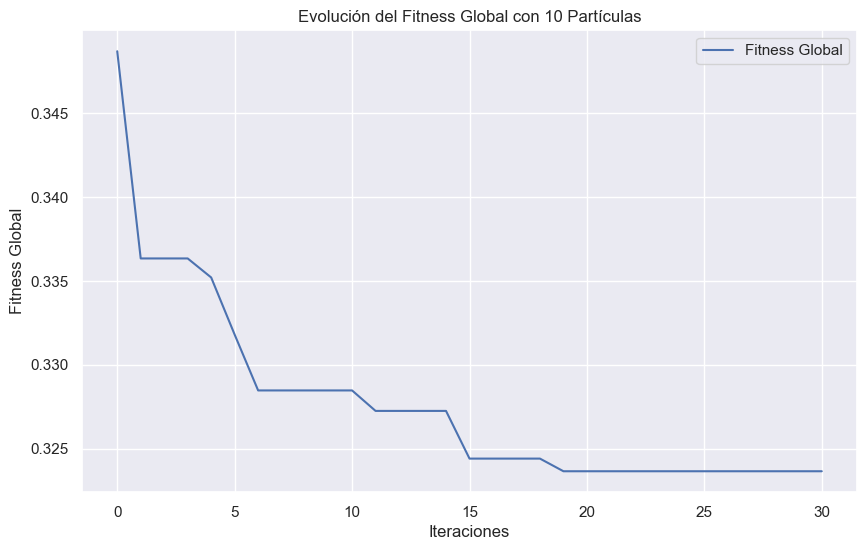

In [16]:
# =============================================================================
#  Algoritmo de Optimización por Enjambre de Partículas (PSO) 
#  adaptado para optimizar hiperparámetros de una Red Neuronal (MLPClassifier).
# =============================================================================

import numpy as np
import random
import numpy.matlib

# Importamos el MLPClassifier para la red neuronal.
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Suponiendo que:
# - Evolucion es un array que contiene el mejor fitness global en cada iteración,
#   desde la iteración 0 hasta la it_max (dimensión: it_max+1).
# - N es el número de partículas.
# - it_max es el número máximo de iteraciones.




crterion_map_hidden_layer_sizes_values={1:(64,),2:(128,),3:(256,),4:(64,64),5:(128,64),6:(128,128),7:(256,128)}#
criterion_map_activation_values={0:"identity",1:"logistic",2:"tanh",3:"relu"}#fijar relu
criterion_map_solver_values={0:"lbfgs",1:"sgd",2:"adam"}#adam 
criterion_map_learning_rate_values={0:"constant",1:"invscaling",2:"adaptive"}#fijar adaptive
criterion_map_early_stopping_values={0:False,1:True}#1


hyperparameter_space = {
    "hidden_layer_sizes_values": [1, 2, 3, 4, 5, 6, 7],
    "activation_values": [0, 1, 2, 3],
    "solver_values": [0, 1, 2],
    "alpha_values": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "learning_rate_values": [0, 1, 2],
    "learning_rate_init_values": [1e-4, 1e-3, 1e-2, 1e-1],
    "max_iter_values": [50, 1000],
    "early_stopping_values": [0, 1]
}


def funObj(x):

    # 3) Crear el MLPClassifier con estos hiperparámetros
    model = MLPClassifier(
        hidden_layer_sizes = crterion_map_hidden_layer_sizes_values[round(x[0])],
        activation         = criterion_map_activation_values[round(x[1])],
        solver             = criterion_map_solver_values[round(x[2])],
        alpha              = round(x[3], 6),
        learning_rate      = criterion_map_learning_rate_values[round(x[4])],
        learning_rate_init = round(x[5], 4),
        max_iter           = round(x[6]),
        early_stopping     = criterion_map_early_stopping_values[round(x[7])]
    )


    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    ce_val = log_loss(y_test, y_pred_proba, labels=np.unique(y_train))

    # Al PSO le conviene minimizar la entropía cruzada, así que retornamos ce_val directamente
    return ce_val


# ===================================
# 3. Parâmetros iniciales de PSO
# ===================================

# d es la dimensión del espacio de búsqueda (uno por cada hiperparámetro).
d = len(hyperparameter_space.keys())

N = 10          # Número de partículas en el enjambre
it = 0         # Iteración inicial
it_max = 30    # Número máximo de iteraciones (puedes ajustarlo)
c1 = 0.2       # Constante cognitiva
c2 = 0.2      # Constante social
w = 0.9
k = 0.5

# Este array guardará la evolución del mejor fitness global por iteración
Evolucion = np.zeros(it_max + 1)

# Definimos los límites inferiores y superiores (lb, ub) para cada dimensión:
# Como se están usando índices discretos, se toman el mínimo y el máximo índice.
lb = [0] * d
ub = [0] * d

# ==================================================
# 4. Clase Particula y generación del enjambre
# ==================================================

class Particula():
    """
    Representa a una partícula del algoritmo PSO.
    """
    def __init__(self):
        """
        Atributos:
            posicion: array de dimensión d con la posición de la partícula.
            velocidad: array de dimensión d con la velocidad de la partícula.
            fit: fitness de la partícula (float).
            mejor_fitness_local: mejor valor de fitness alcanzado por la partícula.
            mejor_posicion_local: posición asociada a su mejor_fitness_local.
        """
        self.posicion = np.repeat(None, d)
        self.velocidad = np.zeros(d) 
        self.fit = np.array(None)
        self.mejor_fitness_local = None
        self.mejor_posicion_local = None


# 4.1. Crear el enjambre (arreglo de Particula)
Particulas = np.array([])
for i in range(N):
    particula = Particula()
    Particulas = np.append(Particulas, particula)

for j in range(d):
    lb[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][0]
    ub[j]=hyperparameter_space[list(hyperparameter_space.keys())[j]][len(hyperparameter_space[list(hyperparameter_space.keys())[j]])-1]

# 4.3. Inicializar las partículas en posiciones aleatorias (uniformes entre lb y ub)
mejor_fitness_global = None
mejor_posicion_global = None

for i in range(N):
    # Asignamos posición aleatoria
    Particulas[i].posicion = [np.random.uniform(lb[j], ub[j]) for j in range(d)]
    
    # Calculamos fitness de esta partícula
    Particulas[i].fit = funObj(Particulas[i].posicion)

    # Inicializamos mejor fitness local y mejor posición local
    Particulas[i].mejor_fitness_local = Particulas[i].fit
    Particulas[i].mejor_posicion_local = Particulas[i].posicion

    # Actualizamos el mejor fitness global si corresponde
    if i == 0 or Particulas[i].fit < mejor_fitness_global:
        mejor_fitness_global = Particulas[i].fit
        mejor_posicion_global = Particulas[i].posicion

Evolucion[0] = mejor_fitness_global
print(f"Iteración 0: Costo(Fitness) = {Evolucion[0]:.4f}, mejor posición global = {mejor_posicion_global}")


# ========================================
# 5. Proceso iterativo de PSO
# ========================================

while it < it_max:
    it += 1
    
    for i in range(N):
        # Convertir a arrays NumPy para operaciones vectoriales
        posicion_array = np.array(Particulas[i].posicion, dtype=float)
        mejor_posicion_local_array = np.array(Particulas[i].mejor_posicion_local, dtype=float)
        mejor_posicion_global_array = np.array(mejor_posicion_global, dtype=float)

        # Cálculo de las velocidades con componente cognitiva y social
        parte1 = c1 * random.uniform(0, 1) * (mejor_posicion_local_array - posicion_array)
        parte2 = c2 * random.uniform(0, 1) * (mejor_posicion_global_array - posicion_array)

        nueva_velocidad = w * Particulas[i].velocidad + parte1 + parte2
        
        Particulas[i].velocidad = nueva_velocidad
        Particulas[i].posicion = Particulas[i].posicion + Particulas[i].velocidad

        # Verificar que las partículas no se salgan de los límites [lb, ub]
        for j in range(d):
            if Particulas[i].posicion[j] < lb[j]:
                Particulas[i].posicion[j] = lb[j]
                Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]
            elif Particulas[i].posicion[j] > ub[j]:
                Particulas[i].posicion[j] = ub[j]
                Particulas[i].velocidad[j] = -Particulas[i].velocidad[j]

        # Limitar la velocidad (inercia) con factor k
        for j in range(d):
            if Particulas[i].velocidad[j] < -k*(ub[j]-lb[j]):
                Particulas[i].velocidad[j] = -k*(ub[j]-lb[j])
            elif Particulas[i].velocidad[j] > k*(ub[j]-lb[j]):
                Particulas[i].velocidad[j] = k*(ub[j]-lb[j])

        # Recalcular el fitness con la nueva posición
        Particulas[i].fit = funObj(Particulas[i].posicion)

        # Actualizar mejor fitness local
        if Particulas[i].fit < Particulas[i].mejor_fitness_local:
            Particulas[i].mejor_fitness_local = Particulas[i].fit
            Particulas[i].mejor_posicion_local = Particulas[i].posicion

        # Actualizar mejor fitness global
        if Particulas[i].mejor_fitness_local < mejor_fitness_global:
            mejor_fitness_global = Particulas[i].mejor_fitness_local
            mejor_posicion_global = Particulas[i].mejor_posicion_local

    Evolucion[it] = mejor_fitness_global
    print(f"Iteración {it}: Costo(Fitness) = {Evolucion[it]:.4f}, mejor posición global = {mejor_posicion_global}")

# Al finalizar, mejor_fitness_global y mejor_posicion_global contienen
# los mejores valores hallados por el PSO.
print("\n========================================")
print(f"Mejor Fitness encontrado: {mejor_fitness_global}")
print(f"Corresponde a un F1 (macro) de: {mejor_fitness_global:.4f}")
#print(f"Mejor posición (hiperparámetros) hallada: {mejor_posicion_global}")
print("========================================")
import matplotlib.pyplot as plt

# Suponiendo que Evolucion es un array que contiene el mejor fitness global en cada iteración
# y N es el número de partículas

plt.figure(figsize=(10, 6))
plt.plot(Evolucion, label='Fitness Global')
plt.xlabel('Iteraciones')
plt.ylabel('Fitness Global')
plt.title(f'Evolución del Fitness Global con {N} Partículas')
plt.legend()
plt.grid(True)
plt.show()
